In [31]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [32]:
#load data
df = pd.read_csv('sales data.csv')

<ipython-input-32-489f14ab7693>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sales data.csv')


In [33]:
df = df.dropna(axis=0)

In [34]:
df.shape

(180960, 9)

In [35]:
df.head()

,Date,Invoice No,Customer ID,Country,Continent,Product Code,Selling Price,Quantity,Sales
0,9/1/17,8,4000027.0,American,North America,262091000000.0,900,1,900
1,9/1/17,8,4000027.0,American,North America,262091000000.0,900,1,900
2,9/1/17,10,4000027.0,American,North America,757000000000.0,1300,1,1300
3,9/1/17,10,4000027.0,American,North America,906000000000.0,600,1,600
4,9/1/17,11,4000027.0,American,North America,254091000000.0,500,1,500


In [36]:
df.dtypes

Date               object
Invoice No          int64
Customer ID       float64
Country            object
Continent          object
Product Code       object
Selling Price       int64
Quantity            int64
Sales               int64
dtype: object

In [37]:
#remove white space contains in columns
df.columns = df.columns.str.replace(' ', '')

In [38]:
#remove white space contains in Continent column
df['Continent'] = df['Continent'].str.strip()

<ipython-input-38-fdb8a8c284a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Continent'] = df['Continent'].str.strip()


In [39]:
df['Continent'].unique()

array(['North America', 'Asia', 'Europe', 'Japan', 'Other', 'Oceania',
       'Asian and Other', 'South America', 'Africa', 'Arab'], dtype=object)

In [40]:
#change date to pandas datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [41]:
#create sales by date and continent
new_df = df.groupby(['Date','Continent'])['Sales'].sum()

In [42]:
#crate a Pandas dataframe
df2 = pd.DataFrame(new_df)
df2  = new_df.reset_index()
df2.head()

,Date,Continent,Sales
0,2017-09-01,Asia,147870
1,2017-09-01,Europe,5400
2,2017-09-01,Japan,73720
3,2017-09-01,North America,15500
4,2017-09-01,Other,16080


In [43]:
df2.shape

(4281, 3)

In [44]:
#prepare sales dataset for Asian customers only
df3 = (df2[df2['Continent'] == 'Asia']
          .groupby(['Date'])['Sales'].sum())

In [45]:
asian = pd.DataFrame(df3)
asian  = df3.reset_index()
asian.head()

,Date,Sales
0,2017-09-01,147870
1,2017-09-02,74920
2,2017-09-03,118120
3,2017-09-04,119510
4,2017-09-05,90360


In [46]:
asian.shape

(728, 2)

In [47]:
#change columns name to Prophet format
asian = asian.rename(columns={'Date':'ds', 'Sales' :'y'})

In [48]:
#resample from daily to weekly data
asian = asian.set_index('ds')
weekly_buyers = asian.resample(rule='W').sum()
weekly_buyers.head()

,y
ds,
2017-09-03,340910
2017-09-10,769905
2017-09-17,542280
2017-09-24,824250
2017-10-01,733970


In [49]:
len(weekly_buyers)

105

<Axes: xlabel='ds'>

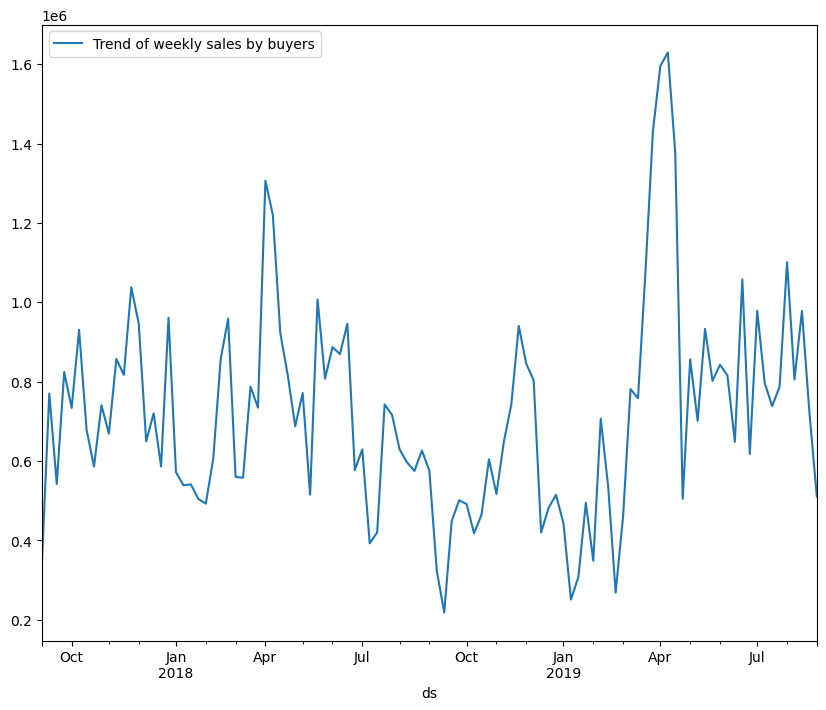

In [50]:
#plot the weekly_sales of Asian buyers
weekly_buyers = weekly_buyers.reset_index()
weekly_buyers.plot(x='ds',y='y',figsize=(10,8),label='Trend of weekly sales by buyers')

In [51]:
#fit with Prophet model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(weekly_buyers);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8hxrcnep/ds6pol3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8hxrcnep/w0wydgzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44089', 'data', 'file=/tmp/tmp8hxrcnep/ds6pol3f.json', 'init=/tmp/tmp8hxrcnep/w0wydgzn.json', 'output', 'file=/tmp/tmp8hxrcnep/prophet_model3_fk21u5/prophet_model-20230627064820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:48:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [52]:
future = model.make_future_dataframe(periods= 8, freq='W')

In [53]:
forecast = model.predict(future)

Text(0.5, 1.0, 'Forecasting sales of Asian buyers for next 8 weeks')

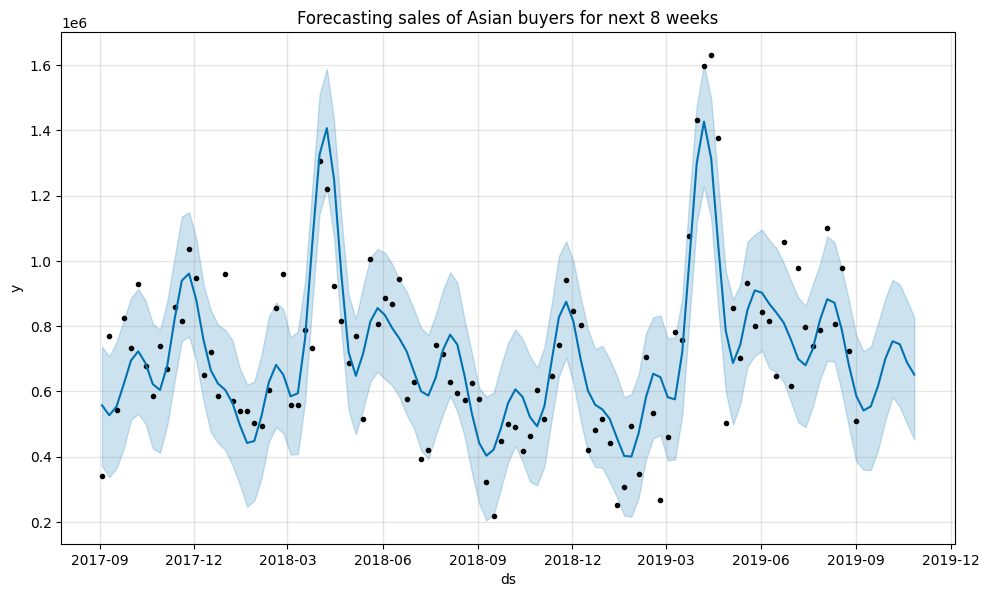

In [54]:
fig = model.plot(forecast);
#a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.xlim()
plt.title("Forecasting sales of Asian buyers for next 8 weeks")


In [55]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
108,2019-09-29,699586.279457,510636.596441,883887.731898
109,2019-10-06,753783.261330,583571.257247,941980.832261
110,2019-10-13,744773.651206,553075.501475,927788.140457
111,2019-10-20,688678.894265,500909.934353,879518.575959
112,2019-10-27,651717.785572,453251.501456,826598.741419


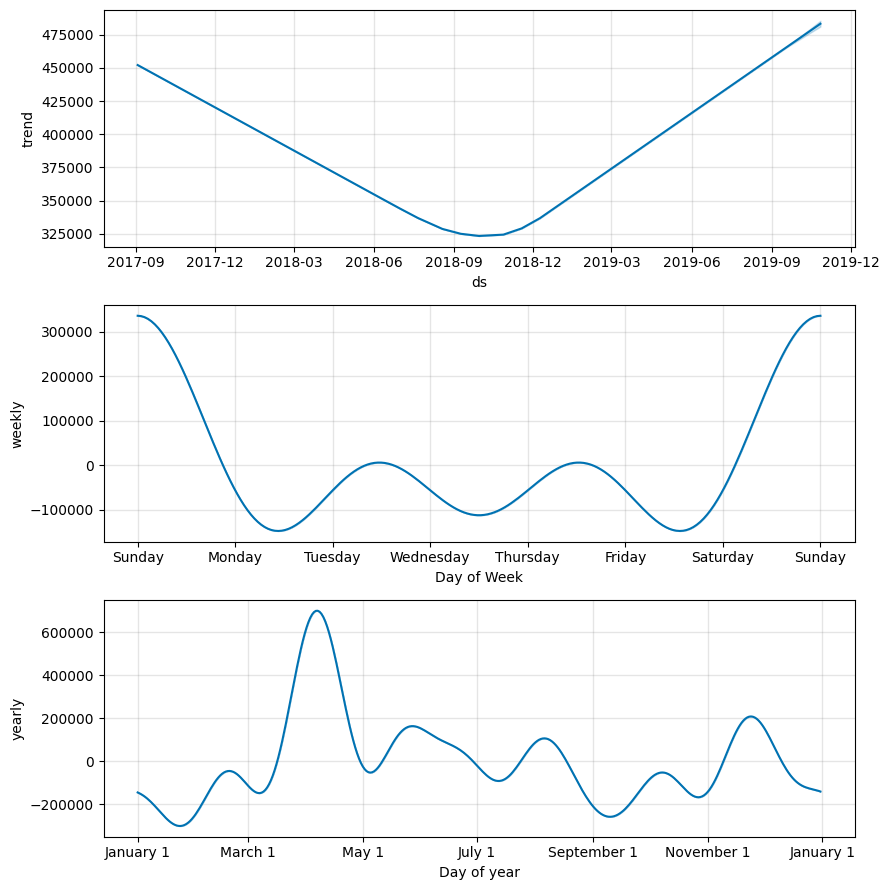

In [56]:
model.plot_components(forecast);

In [57]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='70 W', period='6 W', horizon = '8 W ')

INFO:prophet:Making 5 forecasts with cutoffs between 2019-01-20 00:00:00 and 2019-07-07 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8hxrcnep/xbmeqo12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8hxrcnep/ztkqc_jw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20930', 'data', 'file=/tmp/tmp8hxrcnep/xbmeqo12.json', 'init=/tmp/tmp8hxrcnep/ztkqc_jw.json', 'output', 'file=/tmp/tmp8hxrcnep/prophet_modelse447mzq/prophet_model-20230627064822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8hxrcnep/fe2wztku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8hxrcnep/0po0b0dh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [58]:
df_cv['yhat'] = df_cv['yhat'].astype(int)
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
35,2019-08-04,740356,553950.097233,944291.477056,1100920,2019-07-07
36,2019-08-11,714606,521399.453990,910522.580677,805460,2019-07-07
37,2019-08-18,641247,457424.102838,840245.869682,978150,2019-07-07
38,2019-08-25,561567,349547.383833,759917.630642,723140,2019-07-07
39,2019-09-01,502711,314492.617968,707431.115958,510280,2019-07-07


In [59]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,1.070218e+11,327141.905070,284164.6,0.349801,0.354183,0.457077,0.4
1,14 days,2.313456e+10,152100.503357,124354.2,0.200176,0.184868,0.218654,0.8
2,21 days,6.305668e+10,251110.893242,228613.4,0.273663,0.322024,0.313977,0.4
3,28 days,1.077895e+11,328313.097427,291351.4,0.280674,0.327512,0.322071,0.4
4,35 days,1.156117e+11,340017.140842,278091.4,0.459138,0.251096,0.368687,0.4


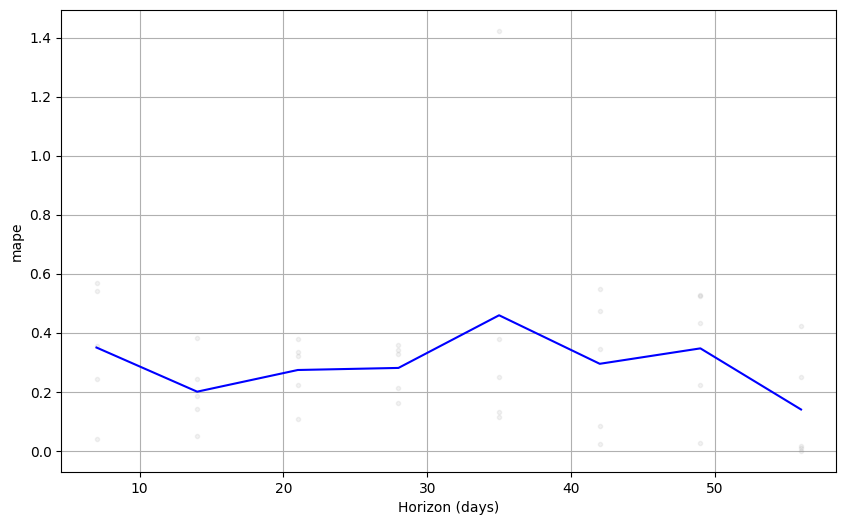

In [60]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')